In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import h5py
path = '/z/omarioni/gradients/_simulations/snap_127/'
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
def printname(name):
    print (name)
snap.visit(printname)

Center
Drk
Drk/Coordinates
Drk/IDs
Drk/Masses
Drk/Potential
Drk/Velocities
Gas
Gas/Coordinates
Gas/IDs
Gas/Masses
Gas/Metallicity
Gas/Potential
Gas/Total_Metallicity
Gas/Velocities
Omega_0
Omega_Baryon
Omega_Lambda
Redshift
Str
Str/Birth_Density
Str/Birth_Position
Str/Birth_Velocities
Str/Coordinates
Str/FormationTime
Str/IDs
Str/Masses
Str/Metallicity
Str/Potential
Str/Total_Metallicity
Str/Velocities
Time
h


In [6]:
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

print ('h = ',h)
print ('Omega Lambda = ', Om_L)
print ('Omega Matter = ', Om_M)

h =  0.6777
Omega Lambda =  0.682
Omega Matter =  0.318


In [3]:
%matplotlib

Using matplotlib backend: agg


In [26]:
# import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines

path = '/z/omarioni/gradients/_simulations/snap_127/'

subh = (0,1,3,4,5)

# for j in range(0,1):
j= 0
snap = h5py.File(path + 'subhalo_'+str('%03d'%subh[j])+'.h5py', 'r')

aexp = snap['/Time'][()]
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

pstr = snap['/Str/Coordinates'][()]
mstr = snap['/Str/Masses'][()]
vstr = snap['/Str/Velocities'][()]

met  = snap['/Str/Metallicity'][()]
sft  = snap['/Str/FormationTime'][()]

FeH = met[:,8]/met[:,0]
age = time.conv2(sft, h, Om_L, Om_M)

xstr = pstr[:,0]*aexp/h
ystr = pstr[:,1]*aexp/h
zstr = pstr[:,2]*aexp/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

v_x = vstr[:,0] *np.sqrt(aexp)
v_y = vstr[:,1] *np.sqrt(aexp)
v_z = vstr[:,2] *np.sqrt(aexp)

#----------------------masas----------------------------
mstr = mstr/h

veloc,=np.where(rstr < 3)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

xn_str = e1x*xstr + e1y*ystr + e1z*zstr
yn_str = e2x*xstr + e2y*ystr + e2z*zstr
zn_str = e3x*xstr + e3y*ystr + e3z*zstr

Rstr = np.sqrt(xn_str**2 + yn_str**2)

mask, = np.where((Rstr<25) & (zn_str<5) & (zn_str>-5))


nbin = 20
med_R,nodo_R = bines.rbin1(Rstr[mask],nbin)

age_4  = np.where(age[mask] > 4)
# age_8  = np.where(age[mask] > 8)
# age_10 = np.where(age[mask] > 10)

rr = Rstr[mask]
zz = zn_str[mask]
mass = mstr[mask]

rr4 = rr[age_4]
rr8 = rr[age_8]
rr10 = rr[age_10]

z4  = np.zeros(nbin)
z8  = np.zeros(nbin)
z10 = np.zeros(nbin)

for i in range(0,nbin):
    zetas4,  = np.where((rr4 >= nodo_R[i])  & (rr4 < nodo_R[i+1]))
#     zetas8,  = np.where((rr8 >= nodo_R[i])  & (rr8 < nodo_R[i+1]))
#     zetas10, = np.where((rr10 >= nodo_R[i]) & (rr10 < nodo_R[i+1]))
#     print (len(zetas4))
    Mbin_4  = np.cumsum(mass[zetas4])
#     Mbin_8  = np.cumsum(mass[zetas8])
#     Mbin_10 = np.cumsum(mass[zetas10])
    
    kk4,  = np.where(Mbin_4  < Mbin_4[-1]/2)
#     kk8,  = np.where(Mbin_8  < Mbin_8[-1]/2)
#     kk10, = np.where(Mbin_10 < Mbin_10[-1]/2)
    
    zeta4  = zz[zetas4]
#     zeta8  = zz[zetas8]
#     zeta10 = zz[zetas10]
    
    z4[i]  = zeta4[kk4][-1]
#     z8[i]  = zeta8[kk8][-1]
#     z10[i] = zeta10[kk10][-1]


/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


In [27]:
print (z4)

[-0.32681906 -0.31978726  0.2884509  -0.50135827 -0.2452082  -0.27342069
  1.44693458 -0.638026    0.76238567  0.22132027 -0.44214734  0.73497123
 -0.57454741  0.37714624  0.19371046  0.29276943 -0.61869973  0.79730463
  0.68925834  3.61732507]


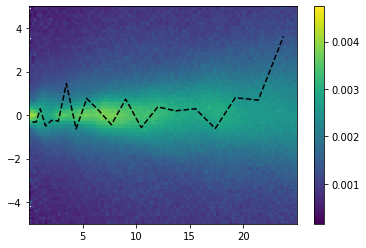

In [28]:
import matplotlib.pyplot as plt
plt.hexbin(Rstr[mask],zn_str[mask],FeH[mask],cmap='viridis')
plt.plot(med_R,z4,ls='--',color='k')
plt.colorbar()
plt.show()

In [10]:
print (FeH)

[0.00549538 0.00180464 0.00324974 ... 0.00024693 0.00075711 0.00045361]


In [10]:
plt.close()

(array([100926., 378722., 678139., 839371., 884780., 956852., 729033.,
        502959., 356501., 292605.]),
 array([ 0.16308884,  1.5152293 ,  2.86737   ,  4.2195106 ,  5.571651  ,
         6.9237914 ,  8.275932  ,  9.628073  , 10.980213  , 12.332354  ,
        13.684494  ], dtype=float32),
 <a list of 10 Patch objects>)

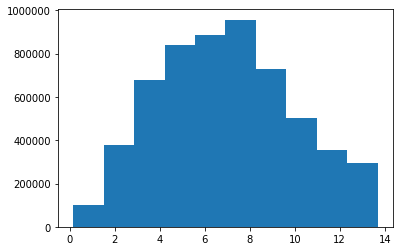

In [16]:
plt.hist(age)